In [13]:
import os
import cv2
import numpy as np
import pickle
from tqdm import tqdm
from scipy.signal import wiener as scipy_wiener
import pywt

In [14]:
IMG_SIZE = (256, 256)
DENOISE_METHOD = "wavelet"
DATASET_DIR = r"C:\Users\Sona\Downloads\official_document"
OUTPUT_DIR = r"C:\Users\Sona\Downloads\official_document_output"

In [15]:
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def resize_to(img, size=IMG_SIZE):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    return img.astype(np.float32) / 255.0

In [16]:
def denoise_wavelet_img(img):
    """Wavelet denoising (simple Haar filter)."""
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
    cH[:] = 0; cV[:] = 0; cD[:] = 0
    return pywt.idwt2((cA, (cH, cV, cD)), 'haar')

In [17]:
def preprocess_image(fpath, method=DENOISE_METHOD):
    """Read image → grayscale → resize → normalize → denoise → residual."""
    img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"⚠️ Skipping unreadable image: {fpath}")
        return None

    img = to_gray(img)
    img = resize_to(img)
    img = normalize_img(img)

    if method == "wiener":
        den = scipy_wiener(img, mysize=(5, 5))
    else:
        den = denoise_wavelet_img(img)
    residual = (img - den).astype(np.float32)
    return residual

In [18]:
def process_dataset(base_dir, expect_dpi=True):
    residuals_dict = {}
    scanners = sorted(os.listdir(base_dir))

    for scanner in tqdm(scanners, desc=f"Processing {os.path.basename(base_dir)}"):
        scanner_dir = os.path.join(base_dir, scanner)
        if not os.path.isdir(scanner_dir):
            continue

        all_residuals = []

        # Case 1: has DPI subfolders (e.g., 150, 300)
        dpi_subfolders = [
            os.path.join(scanner_dir, d)
            for d in os.listdir(scanner_dir)
            if os.path.isdir(os.path.join(scanner_dir, d))
        ]

        if dpi_subfolders:
            for dpi_dir in dpi_subfolders:
                image_files = [
                    os.path.join(dpi_dir, f)
                    for f in os.listdir(dpi_dir)
                    if f.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg"))
                ]
                for img_path in image_files:
                    res = preprocess_image(img_path)
                    if res is not None:
                        all_residuals.append(res)
        else:
            # Case 2: scanner folder directly contains images (no DPI folders)
            image_files = [
                os.path.join(scanner_dir, f)
                for f in os.listdir(scanner_dir)
                if f.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg"))
            ]
            for img_path in image_files:
                res = preprocess_image(img_path)
                if res is not None:
                    all_residuals.append(res)

        residuals_dict[scanner] = all_residuals

    return residuals_dict

In [19]:
print("🔄 Generating residuals...")
residuals = process_dataset(DATASET_DIR)

if residuals is None or len(residuals) == 0:
    print("⚠️ No residuals generated.")
else:
    print(f"✅ Residuals generated: {len(residuals)}")

# Build output path
RES_PATH = os.path.join(OUTPUT_DIR, "residuals_wavelet.pkl")

# ✅ FIX: Create the folder if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

try:
    with open(RES_PATH, "wb") as f:
        pickle.dump(residuals, f)
    print(f"📁 Residuals saved to: {RES_PATH}")
except Exception as e:
    print(f"❌ Error saving residuals: {e}")


🔄 Generating residuals...


Processing official_document: 100%|██████████| 11/11 [04:29<00:00, 24.49s/it]


✅ Residuals generated: 11
📁 Residuals saved to: C:\Users\Sona\Downloads\official_document_output\residuals_wavelet.pkl


In [20]:
print("\n🔄 Computing fingerprints...")
scanner_fps = {}
for scanner, res_list in tqdm(residuals.items()):
    if len(res_list) == 0:
        continue
    stack = np.stack(res_list, axis=0)
    scanner_fps[scanner] = np.mean(stack, axis=0).astype(np.float32)

FP_PATH = os.path.join(OUTPUT_DIR, "scanner_fingerprints.pkl")
FP_KEYS_PATH = os.path.join(OUTPUT_DIR, "fp_keys.npy")

with open(FP_PATH, "wb") as f:
    pickle.dump(scanner_fps, f)
np.save(FP_KEYS_PATH, np.array(sorted(scanner_fps.keys())))

print(f"📁 Fingerprints saved to: {FP_PATH}")


🔄 Computing fingerprints...


100%|██████████| 11/11 [00:00<00:00, 21.24it/s]

📁 Fingerprints saved to: C:\Users\Sona\Downloads\official_document_output\scanner_fingerprints.pkl


In [21]:
from skimage.feature import local_binary_pattern
from scipy.fft import fft2, fftshift

print("\n🔄 Extracting handcrafted features...")

def corr2d(a, b):
    a = a.astype(np.float32).ravel()
    b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / denom) if denom != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(fft2(img))
    mag = np.abs(f)
    h, w = mag.shape
    cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats = [float(np.mean(mag[(r >= bins[i]) & (r < bins[i+1])])) for i in range(K)]
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        return [0.0]*(P+2)
    g = (img - img.min()) / (rng + 1e-8)
    g8 = (g*255).astype(np.uint8)
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    hist, _ = np.histogram(codes, bins=np.arange(P+3), density=True)
    return hist.astype(np.float32).tolist()

# Load fingerprints
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(FP_KEYS_PATH, allow_pickle=True).tolist()

# Feature extraction
features, labels = [], []
for scanner, res_list in tqdm(residuals.items(), desc="Extracting features"):
    for res in res_list:
        v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]
        v_fft = fft_radial_energy(res)
        v_lbp = lbp_hist_safe(res)
        features.append(v_corr + v_fft + v_lbp)
        labels.append(scanner)

FEAT_PATH = os.path.join(OUTPUT_DIR, "features_labels.pkl")
with open(FEAT_PATH, "wb") as f:
    pickle.dump({"features": features, "labels": labels}, f)

print(f"📁 Features saved to: {FEAT_PATH}")


🔄 Extracting handcrafted features...


Extracting features: 100%|██████████| 11/11 [00:43<00:00,  3.92s/it]

📁 Features saved to: C:\Users\Sona\Downloads\official_document_output\features_labels.pkl


In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

features = np.array(features, dtype=np.float32)
labels = np.array(labels)

# Convert residuals → (256,256,1) for CNN
X_img, y_img = [], []
for scanner, res_list in residuals.items():
    for res in res_list:
        X_img.append(np.expand_dims(res, -1))
        y_img.append(scanner)

X_img = np.array(X_img, dtype=np.float32)
y_img = np.array(y_img)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
print(f"Classes found: {list(le.classes_)}")

# Scale features
scaler = StandardScaler()
X_feat_scaled = scaler.fit_transform(features)

# Save all
np.save(os.path.join(OUTPUT_DIR, "X_img.npy"), X_img)
np.save(os.path.join(OUTPUT_DIR, "X_feat.npy"), X_feat_scaled)
np.save(os.path.join(OUTPUT_DIR, "y.npy"), y_encoded)

with open(os.path.join(OUTPUT_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(OUTPUT_DIR, "feature_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("\n🎉 Preprocessing complete!")
print(f"Images: {X_img.shape}, Features: {X_feat_scaled.shape}, Labels: {y_encoded.shape}")
print(f"Data saved in {OUTPUT_DIR}")

Classes found: [np.str_('Canon120-1'), np.str_('Canon120-2'), np.str_('Canon220'), np.str_('Canon9000-1'), np.str_('Canon9000-2'), np.str_('EpsonV370-1'), np.str_('EpsonV370-2'), np.str_('EpsonV39-1'), np.str_('EpsonV39-2'), np.str_('EpsonV550'), np.str_('HP')]

🎉 Preprocessing complete!
Images: (2200, 256, 256, 1), Features: (2200, 27), Labels: (2200,)
Data saved in C:\Users\Sona\Downloads\official_document_output


In [23]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [24]:
BASE_DIR = r"C:\Users\Sona\Downloads\official_document_output"

X_IMG_PATH = os.path.join(BASE_DIR, "X_img.npy")
X_FEAT_PATH = os.path.join(BASE_DIR, "X_feat.npy")
Y_PATH = os.path.join(BASE_DIR, "y.npy")
ENCODER_PATH = os.path.join(BASE_DIR, "label_encoder.pkl")

MODEL_OUT_PATH = os.path.join(BASE_DIR, "scanner_hybrid_final.keras")
HISTORY_OUT_PATH = os.path.join(BASE_DIR, "hybrid_training_history.pkl")

In [25]:
X_img = np.load(X_IMG_PATH)    # shape: (N, 256, 256, 1)
X_feat = np.load(X_FEAT_PATH)  # shape: (N, M)
y = np.load(Y_PATH)

with open(ENCODER_PATH, "rb") as f:
    le = pickle.load(f)

num_classes = len(le.classes_)
print(f"📁 Loaded data:")
print(f"  X_img: {X_img.shape}")
print(f"  X_feat: {X_feat.shape}")
print(f"  y: {y.shape}")
print(f"  Classes: {list(le.classes_)}")

📁 Loaded data:
  X_img: (2200, 256, 256, 1)
  X_feat: (2200, 27)
  y: (2200,)
  Classes: [np.str_('Canon120-1'), np.str_('Canon120-2'), np.str_('Canon220'), np.str_('Canon9000-1'), np.str_('Canon9000-2'), np.str_('EpsonV370-1'), np.str_('EpsonV370-2'), np.str_('EpsonV39-1'), np.str_('EpsonV39-2'), np.str_('EpsonV550'), np.str_('HP')]


In [26]:
X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img, X_feat, y, test_size=0.2, random_state=42, stratify=y
)

y_tr_cat = to_categorical(y_tr, num_classes)
y_te_cat = to_categorical(y_te, num_classes)

In [27]:
IMG_SHAPE = (256, 256, 1)
FEAT_DIM = X_feat.shape[1]

# Image input for CNN branch
img_in = keras.Input(shape=IMG_SHAPE, name="residual")

# Handcrafted features input
feat_in = keras.Input(shape=(FEAT_DIM,), name="handcrafted")

# --- CNN branch ---
hp_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32).reshape((3, 3, 1, 1))
hp_layer = layers.Conv2D(1, (3, 3), padding="same", use_bias=False, trainable=False, name="hp_filter")
hp_layer.build((None, 256, 256, 1))
hp_layer.set_weights([hp_kernel])
hp = hp_layer(img_in)

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(hp)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling2D()(x)

# --- Handcrafted feature branch ---
f = layers.Dense(64, activation="relu")(feat_in)
f = layers.Dropout(0.3)(f)

# --- Fusion ---
z = layers.Concatenate()([x, f])
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.4)(z)
out = layers.Dense(num_classes, activation="softmax")(z)

model = keras.Model(inputs=[img_in, feat_in], outputs=out)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ residual            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hp_filter (Conv2D)  │ (None, 256, 256,  │          9 │ residual[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ hp_filter[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ handcrafted         │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,792 │ handcrafted[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     49,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 11)        │      2,827 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 146,708 (573.08 KB)

 Trainable params: 146,699 (573.04 KB)

 Non-trainable params: 9 (36.00 B)

In [28]:
import tensorflow as tf
BATCH = 32

train_ds = tf.data.Dataset.from_tensor_slices(((X_img_tr, X_feat_tr), y_tr_cat))\
    .shuffle(len(y_tr_cat)).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te_cat))\
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, monitor="val_accuracy"),
    keras.callbacks.ModelCheckpoint(MODEL_OUT_PATH, save_best_only=True, monitor="val_accuracy")
]

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 712ms/step - accuracy: 0.3068 - loss: 1.8675 - val_accuracy: 0.5159 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 721ms/step - accuracy: 0.4642 - loss: 1.3209 - val_accuracy: 0.5136 - val_loss: 1.1187 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 779ms/step - accuracy: 0.4915 - loss: 1.1640 - val_accuracy: 0.5886 - val_loss: 0.9725 - learning_rate: 0.0010
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 772ms/step - accuracy: 0.5426 - loss: 1.0367 - val_accuracy: 0.6432 - val_loss: 0.8900 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 789ms/step - accuracy: 0.5778 - loss: 0.9608 - val_accuracy: 0.6636 - val_loss: 0.8257 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 715ms/step - accuracy: 0.6017 - loss: 0.9122 - val_accuracy: 0.6523 - val_loss: 0.7733 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 802ms/step - accuracy: 0.6199 - loss: 0.

In [29]:
final_acc = history.history["val_accuracy"][-1]
print(f"📊 Final Validation Accuracy: {final_acc * 100:.2f}%")




📊 Final Validation Accuracy: 83.86%


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step


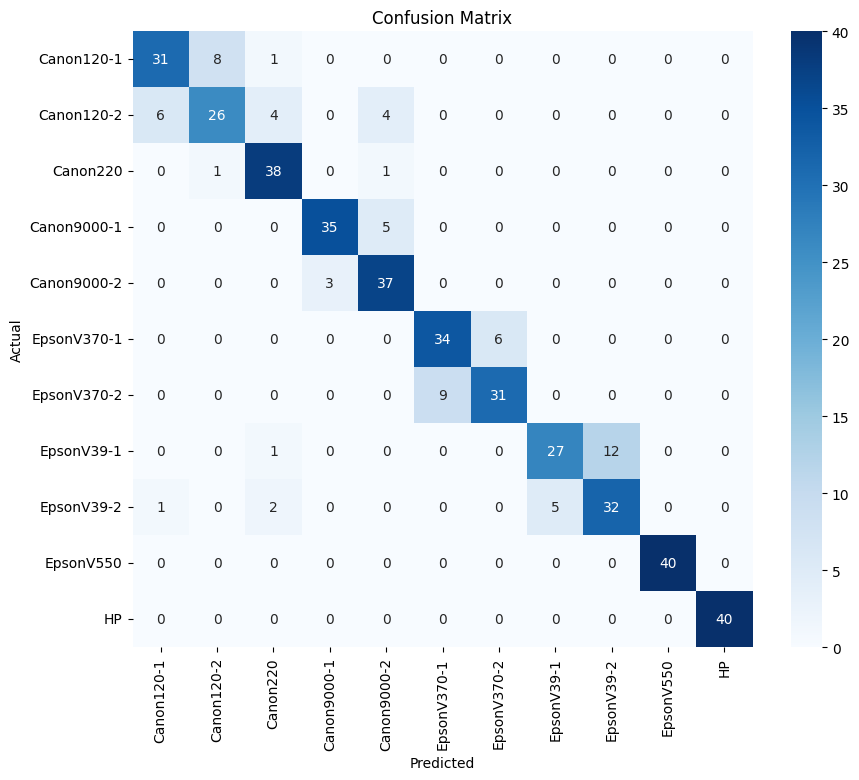

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict([X_img_te, X_feat_te])
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_te, y_pred)
class_names = le.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
